## 6 训练分类器

In [1]:
# 6.1 加载数据。数据预处理。将数据集加载到内存当中。dataloader是加载器。只在调用数据的时候进行惰性加载。
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(.5,.5,5))]
)
trainset = torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,batch_size=4,shuffle=True,num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)

testloader = torch.utils.data.DataLoader(testset,batch_size=4,num_workers=2)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


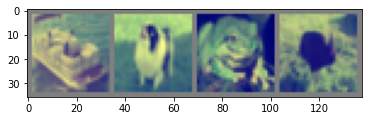

torch.Size([4, 3, 32, 32])
 ship   dog  frog  bird


In [2]:
# 使用迭代器工具，显示一部分图像。
import matplotlib.pylab as plt
import numpy as np 

def imshow(img):
    img = img/2+0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

dataiter = iter(trainloader)
images,labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(images.shape)
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [11]:
# 2 定义卷积神经网络

import torch.nn as nn
import torch.nn.functional as F 

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # print(x.shape)
        return x

net = Net()

In [12]:
# 3 定义损失函数
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

# 训练网络

for epoch in range(2):
    running_loss = 0.0
    for i,data in enumerate(trainloader,0):
        inputs,labels = data
        optimizer.zero_grad()
        # forward
        outputs = net(inputs)
        # calculate loss
        loss = criterion(outputs,labels)
        # backward
        loss.backward()
        # optimize
        optimizer.step()

        running_loss += loss.item()
        if i%2000 == 1999:
            print(inputs.shape,outputs.shape,labels.shape)
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Trainning')


torch.Size([4, 3, 32, 32]) torch.Size([4, 10]) torch.Size([4])
[1,  2000] loss: 2.285
torch.Size([4, 3, 32, 32]) torch.Size([4, 10]) torch.Size([4])
[1,  4000] loss: 2.054
torch.Size([4, 3, 32, 32]) torch.Size([4, 10]) torch.Size([4])
[1,  6000] loss: 1.802
torch.Size([4, 3, 32, 32]) torch.Size([4, 10]) torch.Size([4])
[1,  8000] loss: 1.654
torch.Size([4, 3, 32, 32]) torch.Size([4, 10]) torch.Size([4])
[1, 10000] loss: 1.562
torch.Size([4, 3, 32, 32]) torch.Size([4, 10]) torch.Size([4])
[1, 12000] loss: 1.502
torch.Size([4, 3, 32, 32]) torch.Size([4, 10]) torch.Size([4])
[2,  2000] loss: 1.430
torch.Size([4, 3, 32, 32]) torch.Size([4, 10]) torch.Size([4])
[2,  4000] loss: 1.422
torch.Size([4, 3, 32, 32]) torch.Size([4, 10]) torch.Size([4])
[2,  6000] loss: 1.364
torch.Size([4, 3, 32, 32]) torch.Size([4, 10]) torch.Size([4])
[2,  8000] loss: 1.324
torch.Size([4, 3, 32, 32]) torch.Size([4, 10]) torch.Size([4])
[2, 10000] loss: 1.330
torch.Size([4, 3, 32, 32]) torch.Size([4, 10]) torch.S

In [42]:
# 保存模型
path = './cifar_net.pth'
torch.save(net.state_dict(),path)

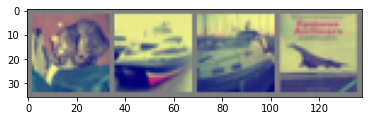

GroundTruth:    cat  ship  ship plane


In [43]:
dataiter = iter(testloader)
images,labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [44]:
# 加载模型

net = Net()
net.load_state_dict(torch.load(path))

<All keys matched successfully>

In [45]:
# 使用模型进行简单的预测
outputs = net(images)
_,predicted = torch.max(outputs,1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


In [46]:

print(classes)

('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [47]:
# 测试总体的表现。
correct = 0
total =0

with torch.no_grad():
    for data in testloader:
        images,labels = data
        outputs = net(images)
        print(outputs.shape)
        _,predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(100*correct/total)

53.9


In [48]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 52 %
Accuracy of   car : 47 %
Accuracy of  bird : 46 %
Accuracy of   cat : 36 %
Accuracy of  deer : 45 %
Accuracy of   dog : 38 %
Accuracy of  frog : 70 %
Accuracy of horse : 56 %
Accuracy of  ship : 83 %
Accuracy of truck : 62 %


In [49]:
# 在GPU上进行训练
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

print(device)

net.to(device)

inputs,labels = data[0].to(device),data[1].to(device)

cpu
